In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta
'''%pip install chardet'''

### Step 1: Data Loading and Preprocessing

In [46]:
# Load datasets
takehome_users = pd.read_csv("takehome_users.csv",encoding= 'ISO-8859-1')
takehome_engagement = pd.read_csv("takehome_user_engagement.csv",encoding='ISO-8859-1')


# Convert timestamps to datetime format
takehome_users['last_session_creation_time'] = pd.to_datetime(takehome_users['last_session_creation_time'], unit='s')
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time'])

takehome_engagement['time_stamp'] = pd.to_datetime(takehome_engagement['time_stamp'])


In [47]:
takehome_users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [48]:
takehome_engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [49]:
# Check for missing values
print(takehome_users.isnull().sum())

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


In [50]:
print(takehome_engagement.isnull().sum())

time_stamp    0
user_id       0
visited       0
dtype: int64


### Step 2: Feature Engineering

In [51]:
# Calculate the number of logins in the past 7 days for each user
takehome_engagement['week'] = takehome_engagement['time_stamp'].dt.to_period('W')
login_counts = takehome_engagement.groupby(['user_id', 'week']).size().reset_index(name='login_count')

In [52]:
# Identify adopted users
adopted_users = login_counts[login_counts['login_count'] >= 3]['user_id'].unique()
takehome_users['adopted_user'] = takehome_users['object_id'].isin(adopted_users).astype(int)

In [53]:
takehome_users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1


### Step 3: Exploratory Data Analysis (EDA)

We will perform EDA to understand the distribution of features and their relationship with user adoption.

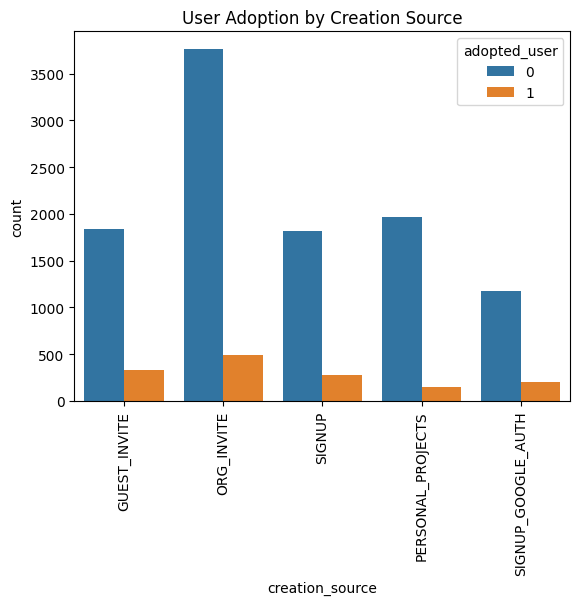

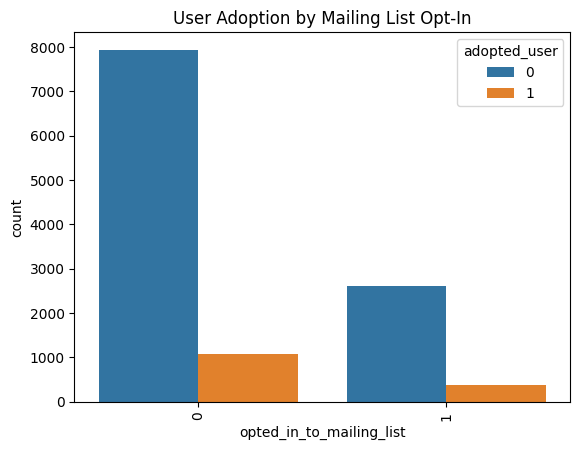

"enabled_for_marketing_drip\t\n# Visualize the distribution of enabled_for_marketing_drip\nsns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=users)\nplt.xticks(rotation=90)\nplt.title('User Adoption by enabled_for_marketing_drip')\nplt.show()"

In [54]:
# Visualize the distribution of creation_source
sns.countplot(x='creation_source', hue='adopted_user', data=users)
plt.xticks(rotation=90)
plt.title('User Adoption by Creation Source')
plt.show()

# Visualize the distribution of mailing list opt-in
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=users)
plt.xticks(rotation=90)
plt.title('User Adoption by Mailing List Opt-In')
plt.show()


### Step 4: Model Training and Evaluation

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Select features and target
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
X = pd.get_dummies(users[features])
y = users['adopted_user']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334
Confusion Matrix:
 [[2972  197]
 [ 403   28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3169
           1       0.12      0.06      0.09       431

    accuracy                           0.83      3600
   macro avg       0.50      0.50      0.50      3600
weighted avg       0.79      0.83      0.81      3600



Accuracy of 83.33% looks good.
Model Performance Summary
Your model achieved an accuracy of 83.33%, which is quite good. However, there are some important aspects to note from the confusion matrix and classification report.

Explaining Confusion Matrix:
[[2972  197]
 [ 403   28]]
True Negatives (2972): The model correctly predicted non-adopted users.

False Positives (197): The model incorrectly predicted non-adopted users as adopted.

False Negatives (403): The model incorrectly predicted adopted users as non-adopted.

True Positives (28): The model correctly predicted adopted users.

Explaining Classification Report:

Class 0 (Non-Adopted Users):
Precision: 0.88 (88%)
Recall: 0.94 (94%)
F1-Score: 0.91 (91%)


Class 1 (Adopted Users):
Precision: 0.12 (12%)
Recall: 0.06 (6%)
F1-Score: 0.09 (9%)


Overall:
Accuracy: 83.33%
Precision: 0.50
Recall: 0.50
F1-Score: 0.50

Weighted Avg:
Precision: 0.79
Recall: 0.83
F1-Score: 0.81

Insights:
High Accuracy: The overall accuracy of the model is high, but it may be skewed by the large number of non-adopted users.

Class Imbalance: There is a significant class imbalance between adopted users (431) and non-adopted users (3169).

Poor Performance for Adopted Users: The model performs poorly in predicting adopted users, with low precision (12%), recall (6%), and F1-score (9%).

### Summary
EDA Graphs: Included in the attached visuals 
Factors Considered
- Creation Source: Different onboarding methods might influence user engagement.
- Email Preferences: Opting into mailing lists and marketing drips might correlate with higher engagement.
- Inviter Influence: Users invited by other users might show different engagement patterns.

 Further Research
- Addressing Class Imbalance: Using techniques like oversampling, undersampling, or SMOTE to balance the dataset.
- Feature Enrichment: Incorporating additional features such as session duration and activity frequency.
- Model Tuning: Experimenting with different models and hyperparameters to improve minority class prediction.

 Conclusion
The analysis identified key factors that influence user adoption, but further work is needed to improve the prediction of adopted users. Addressing class imbalance and enhancing features are recommended next steps.

